# 1. Load dataset

#### In this assignment, you are expected to build a model that classifies given news article in Azerbaijani into one of the pre-defined six categories. You will need to train your model on a dataset of 50000 news examples.
#### You will need to read the data from data file (news.xlsx). It contains three columns: news category, news title, and the news content. Split the data into train and test sets. Reserve 20% of the data for testing.

In [1]:
!pip install wordcloud


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\azerm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\azerm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\azerm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
dataset = pd.read_excel("news.xlsx")
dataset.head()

,Category,Title,News_Article
0,Maraqlı,Naviforce Sport Saat 2016 ilə zövqlərin ahəngi,Naviforce Sport Saat 2016 Yapon Mexanizmi Yapo...
1,Maraqlı,"Sinir ,oynaq , sinir bel ağrılarına 3 gündə son !","ŞOK ! ŞOK ! ŞOK ! Xanımlar və bəylər , bel və ..."
2,Maraqlı,Dəyərindən qat-qat aşağı qiymətə Mənzil,Dəyərindən qat-qat Aşağı Qiymətə. Həzi Aslanov...
3,İdman,2024 və 2028-ci il olimpiadalarının keçiriləcə...,2028-ci il Yay Olimpiya və Paralimpiya Oyunla...
4,Dünya,Türkiyədə zəlzələ,Türkiyədə daha bir zəlzələ meydana gəlib. L...


In [4]:
dataset.shape


(50000, 3)

In [5]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Category      50000 non-null  object
 1   Title         50000 non-null  object
 2   News_Article  50000 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [6]:
dataset['Category'].value_counts()


Maraqlı         15865
Dünya           13474
Siyasət          6541
İqtisadiyyat     6368
İdman            6205
Mədəniyyət       1547
Name: Category, dtype: int64

In [7]:
# Associate Category names with numerical index and save it in new column CategoryId
target_category = dataset['Category'].unique()
print(target_category)

['Maraqlı' 'İdman' 'Dünya' 'Siyasət' 'İqtisadiyyat' 'Mədəniyyət']


In [8]:
dataset['CategoryId'] = dataset['Category'].factorize()[0]
dataset.head()

,Category,Title,News_Article,CategoryId
0,Maraqlı,Naviforce Sport Saat 2016 ilə zövqlərin ahəngi,Naviforce Sport Saat 2016 Yapon Mexanizmi Yapo...,0
1,Maraqlı,"Sinir ,oynaq , sinir bel ağrılarına 3 gündə son !","ŞOK ! ŞOK ! ŞOK ! Xanımlar və bəylər , bel və ...",0
2,Maraqlı,Dəyərindən qat-qat aşağı qiymətə Mənzil,Dəyərindən qat-qat Aşağı Qiymətə. Həzi Aslanov...,0
3,İdman,2024 və 2028-ci il olimpiadalarının keçiriləcə...,2028-ci il Yay Olimpiya və Paralimpiya Oyunla...,1
4,Dünya,Türkiyədə zəlzələ,Türkiyədə daha bir zəlzələ meydana gəlib. L...,2


In [9]:
# Create a new pandas dataframe "category", which only has unique Categories, also sorting this list in order of CategoryId values
category = dataset[['Category', 'CategoryId']].drop_duplicates().sort_values('CategoryId')
category

,Category,CategoryId
0,Maraqlı,0
3,İdman,1
4,Dünya,2
7,Siyasət,3
14,İqtisadiyyat,4
89,Mədəniyyət,5


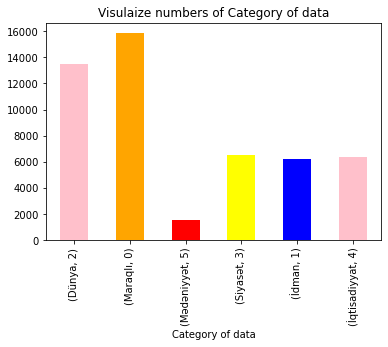

In [10]:
dataset.groupby('Category').CategoryId.value_counts().plot(kind = "bar", color = ["pink", "orange", "red", "yellow", "blue"])
plt.xlabel("Category of data")
plt.title("Visulaize numbers of Category of data")
plt.show()

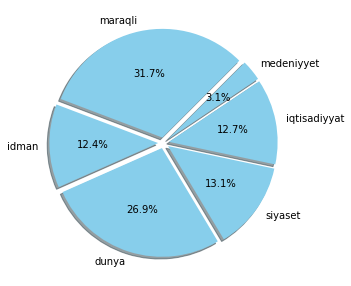

In [11]:
fig = plt.figure(figsize = (5,5))
colors = ["skyblue"]
maraqli = dataset[dataset['CategoryId'] == 0 ]
idman = dataset[dataset['CategoryId'] == 1 ]
dunya = dataset[dataset['CategoryId'] == 2]
siyaset = dataset[dataset['CategoryId'] == 3]
iqtisadiyyat = dataset[dataset['CategoryId'] == 4]
medeniyyet = dataset[dataset['CategoryId'] == 5]
count = [maraqli['CategoryId'].count(), idman['CategoryId'].count(), dunya['CategoryId'].count(), siyaset['CategoryId'].count(), iqtisadiyyat['CategoryId'].count(),medeniyyet['CategoryId'].count()]
pie = plt.pie(count, labels = ['maraqli', 'idman', 'dunya', 'siyaset', 'iqtisadiyyat',"medeniyyet"],
              autopct = "%1.1f%%",
              shadow = True,
              colors = colors,
              startangle = 45,
              explode = (0.05, 0.05, 0.05, 0.05,0.05,0.05))

In [12]:
def remove_tags(text):
    remove = re.compile(r'')
    return re.sub(remove, '', text)
dataset['News_Article'] = dataset['News_Article'].apply(remove_tags)
dataset['Title'] = dataset['Title'].apply(remove_tags)


In [13]:
def special_char(text):
    reviews = ''
    for x in text:
        if x.isalnum():
            reviews = reviews + x
        else:
            reviews = reviews + ' '
    return reviews
dataset['News_Article'] = dataset['News_Article'].apply(special_char)
dataset['Title'] = dataset['Title'].apply(special_char)


In [14]:
def convert_lower(text):
    return text.lower()
dataset['News_Article'] = dataset['News_Article'].apply(convert_lower)
dataset['Title'] = dataset['Title'].apply(convert_lower)


In [15]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return [x for x in words if x not in stop_words]
dataset['News_Article'] = dataset['News_Article'].apply(remove_stopwords)
dataset['Title'] = dataset['Title'].apply(remove_stopwords)



In [16]:
def lemmatize_word(text):
    wordnet = WordNetLemmatizer()
    return " ".join([wordnet.lemmatize(word) for word in text])
dataset['News_Article'] = dataset['News_Article'].apply(lemmatize_word)
dataset['Title'] = dataset['Title'].apply(lemmatize_word)


In [17]:
dataset.to_csv('news_preprocessed.csv', index=False)

# 2. Data preprocessing

In [24]:
x = dataset["News_Article"]
y = dataset['CategoryId']

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
x = np.array(dataset.iloc[:,0].values)
y = np.array(dataset.CategoryId.values)
cv = CountVectorizer(max_features = 5000)
x = cv.fit_transform(dataset["News_Article"]).toarray()
print("X.shape = ",x.shape)
print("y.shape = ",y.shape)

X.shape =  (50000, 5000)
y.shape =  (50000,)


In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0, shuffle = True)
print(len(x_train))
print(len(x_test))

35000
15000


In [21]:
perform_list = [ ]


In [22]:
def run_model(model_name, est_c, est_pnlty):

    mdl=''

    if model_name == 'Logistic Regression':

        mdl = LogisticRegression()

    elif model_name == 'Random Forest':

        mdl = RandomForestClassifier(n_estimators=100 ,criterion='entropy' , random_state=0)

    elif model_name == 'Multinomial Naive Bayes':

        mdl = MultinomialNB(alpha=1.0,fit_prior=True)

    elif model_name == 'Support Vector Classifer':
        mdl = SVC()

    elif model_name == 'Decision Tree Classifier':

        mdl = DecisionTreeClassifier()

    elif model_name == 'K Nearest Neighbour':

        mdl = KNeighborsClassifier(n_neighbors=10 , metric= 'minkowski' , p = 4)

    elif model_name == 'Gaussian Naive Bayes':

        mdl = GaussianNB()

    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(x_train, y_train)

    y_pred = oneVsRest.predict(x_test)

    # Performance metrics

    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)

    # Get precision, recall, f1 scores

    precision, recall, f1score, support = score(y_test, y_pred, average='micro')

    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')

    print(f'Precision : {precision}')

    print(f'Recall : {recall}')
    print(f'F1-score : {f1score}')

    # Add performance parameters to list

    perform_list.append(dict([

    ('Model', model_name),

    ('Test Accuracy', round(accuracy, 2)),

    ('Precision', round(precision, 2)),

    ('Recall', round(recall, 2)),

    ('F1', round(f1score, 2))

    ]))

#### You are expected to extract features from the news articles using bag-of-words and tf-idf representation techniques. You can use library tools (CountVectorizer, TfidfVectorizer) for this purpose. You may want to limit the vocabulary size by choosing most frequent 3000 tokens. Experiment with different sizes.

In [23]:
dataset

,Category,Title,News_Article,CategoryId
0,Maraqlı,naviforce sport saat 2016 ilə zövqlərin ahəngi,naviforce sport saat 2016 yapon mexanizmi yapo...,0
1,Maraqlı,sinir oynaq sinir bel ağrılarına 3 gündə son,şok şok şok xanımlar və bəylər bel və boyun ağ...,0
2,Maraqlı,dəyərindən qat qat aşağı qiymətə mənzil,dəyərindən qat qat aşağı qiymətə həzi aslanov ...,0
3,İdman,2024 və 2028 ci il olimpiadalarının keçiriləcə...,2028 ci il yay olimpiya və paralimpiya oyunlar...,1
4,Dünya,türkiyədə zəlzələ,türkiyədə daha bir zəlzələ meydana gəlib lent ...,2
...,...,...,...,...
49995,Siyasət,əli kərimli terrorçularla da əməkdaşlığa hazır...,axcp sədri milli şura nın mitinqində qəsdən qa...,3
49996,Siyasət,elşən musayev bəlkə elə terrorist əli kərimlin...,ümumiyyətlə milli şuraya xoş olan hətta onları...,3
49997,Dünya,i̇stanbulda 52 mərtəbəli binada yanğın baş verib,türkiyənin i̇stanbul şəhərinin ataşehir rayonu...,2
49998,Dünya,onlar cinayətkarlardır və bir bir məhv edilirl...,rusiyanı tərk edərək i̇şi̇d sıralarında döyüşə...,2


# 3. Modeling

#### For each of the a) logistic regression, b) naïve Bayes, c) stochastic gradient descent classifier, and d) random forest classifier:
- Train it on the training data with Tf-idf representations
- Test the model using test set
- Achieve accuracy rate of ~80%
- Evaluate precision, recall, and F1 scores
- Construct confusion matrix
#### You can use LogisticRegression, MultinomialNB, SGDClassifier, and RandomForestClassifier